In [2]:
import keras
from keras.models import *
from keras.layers import *
from keras.optimizers import *
from keras.preprocessing.image import ImageDataGenerator
import tensorflow as tf
import numpy as np
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers import Flatten
from keras.constraints import maxnorm
from keras.optimizers import SGD
from keras.layers.convolutional import Conv2D
from keras.layers.convolutional import MaxPooling2D
from keras.utils import np_utils

In [ ]:
import cv2,os

data_path='/content/drive/MyDrive/Data/pneumonia/chest_xray/train'
categories=os.listdir(data_path)
labels=[i for i in range(len(categories))]

label_dict=dict(zip(categories,labels)) #empty dictionary

print(label_dict)
print(categories)
print(labels)

{'NORMAL': 0, 'PNEUMONIA': 1}
['NORMAL', 'PNEUMONIA']
[0, 1]


In [ ]:
img_size=224
data=[]
target=[]


for category in categories:
    folder_path=os.path.join(data_path,category)
    img_names=os.listdir(folder_path)
        
    for img_name in img_names:
        img_path=os.path.join(folder_path,img_name)
        img=cv2.imread(img_path)

        try:
            gray=cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)           
            #Coverting the image into gray scale
            resized=cv2.resize(gray,(img_size,img_size))
            #resizing the gray scale into 224x224, since we need a fixed common size for all the images in the dataset
            data.append(resized)
            target.append(label_dict[category])
            #appending the image and the label(categorized) into the list (dataset)

        except Exception as e:
            print('Exception:',e)
            #if any exception rasied, the exception will be printed here. And pass to the next image

In [ ]:
import numpy as np

data=np.array(data)/255.0
data=np.reshape(data,(data.shape[0],img_size,img_size,1))
target=np.array(target)

from keras.utils import np_utils

new_target=np_utils.to_categorical(target)

In [ ]:
np.save('coviddata',data)
np.save('covidnew_target',new_target)
np.save('covidtarget',target) 

In [ ]:
print(data.shape[1:])

(224, 224, 1)


In [ ]:
from keras.models import Sequential,Model
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D,Activation,MaxPooling2D
from keras.utils import normalize
from keras.layers import Concatenate
from keras import Input
from keras.callbacks import ModelCheckpoint

input_shape=data.shape[1:] 

inp=Input(shape=input_shape)
model = Sequential()
model.add(Conv2D(256,3,padding='same',activation='relu',input_shape=input_shape,strides=2))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Conv2D(128,(5,5)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Conv2D(256,(7,7)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Conv2D(128,(3,3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Conv2D(64,(1,1)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(1,1)))


model.add(Flatten())
model.add(Dropout(0.5))
model.add(Dense(256,activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(128,activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1,input_dim=128,activation='sigmoid'))
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['binary_accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 112, 112, 256)     2560      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 56, 56, 256)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 52, 52, 128)       819328    
_________________________________________________________________
activation (Activation)      (None, 52, 52, 128)       0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 26, 26, 128)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 20, 20, 256)       1605888   
_________________________________________________________________
activation_1 (Activation)    (None, 20, 20, 256)       0

In [ ]:
from sklearn.model_selection import train_test_split
train_data,test_data,train_target,test_target=train_test_split(data,target,test_size=0.3)

In [ ]:
checkpoint = ModelCheckpoint('model-{epoch:03d}.model',monitor='val_loss',verbose=0,save_best_only=True,mode='auto')
history=model.fit(train_data,train_target,epochs=20,callbacks=[checkpoint],validation_split=0.1)

Epoch 1/20
51/51 [==============================] - 45s 220ms/step - loss: 0.7116 - binary_accuracy: 0.5025 - val_loss: 0.6052 - val_binary_accuracy: 0.5363
INFO:tensorflow:Assets written to: model-001.model/assets
Epoch 2/20
51/51 [==============================] - 8s 160ms/step - loss: 0.4901 - binary_accuracy: 0.7367 - val_loss: 0.0713 - val_binary_accuracy: 0.9777
INFO:tensorflow:Assets written to: model-002.model/assets
Epoch 3/20
51/51 [==============================] - 8s 161ms/step - loss: 0.1225 - binary_accuracy: 0.9580 - val_loss: 0.0545 - val_binary_accuracy: 0.9777
INFO:tensorflow:Assets written to: model-003.model/assets
Epoch 4/20
51/51 [==============================] - 8s 159ms/step - loss: 0.1036 - binary_accuracy: 0.9663 - val_loss: 0.0243 - val_binary_accuracy: 0.9944
INFO:tensorflow:Assets written to: model-004.model/assets
Epoch 5/20
51/51 [==============================] - 8s 161ms/step - loss: 0.0967 - binary_accuracy: 0.9661 - val_loss: 0.0456 - val_binary_accu

In [ ]:
print(model.evaluate(test_data,test_target))

24/24 [==============================] - 4s 168ms/step - loss: 0.0541 - binary_accuracy: 0.9883
[0.05405038222670555, 0.9882506728172302]


In [ ]:
model.save('Covid_model_2.h5')

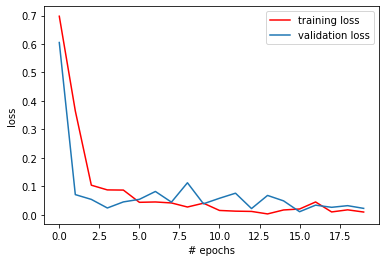

In [ ]:
from matplotlib import pyplot as plt

plt.plot(history.history['loss'],'r',label='training loss')
plt.plot(history.history['val_loss'],label='validation loss')
plt.xlabel('# epochs')
plt.ylabel('loss')
plt.legend()
plt.show()

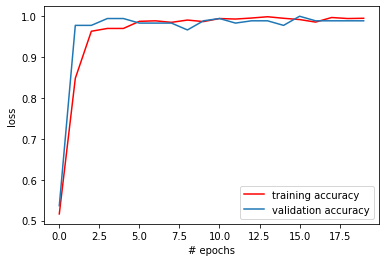

In [ ]:
plt.plot(history.history['binary_accuracy'],'r',label='training accuracy')
plt.plot(history.history['val_binary_accuracy'],label='validation accuracy')
plt.xlabel('# epochs')
plt.ylabel('loss')
plt.legend()
plt.show()

In [6]:
from tensorflow import keras
model = keras.models.load_model('/content/drive/MyDrive/Covid_model_2.h5')

In [7]:
import numpy as np
from keras.preprocessing import image

images = image.load_img("/content/drive/MyDrive/Covid_Data/COVID/COVID (1053).png", target_size=(224,224))    
x = image.img_to_array(images)
x = tf.image.rgb_to_grayscale(x)
x = np.expand_dims(x, axis=0)
x = x/255.0

model.predict(x)

array([[0.99996126]], dtype=float32)

In [8]:
import numpy as np
from keras.preprocessing import image

images = image.load_img("/content/drive/MyDrive/Data/pneumonia/chest_xray/test/NORMAL/IM-0011-0001.jpeg", target_size=(224,224))    
x = image.img_to_array(images)
x = tf.image.rgb_to_grayscale(x)
x = np.expand_dims(x, axis=0)
x = x/255.0

model.predict(x)

array([[5.861462e-05]], dtype=float32)